In [1]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import getpass  #this might not be needed anymore
from os import environ, name
from functions import *
from random import shuffle
from random import seed
np.set_printoptions(precision=2)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 25, 15

### Loading the data

In [118]:
PATH = '/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
def get_path(path = PATH):
    if os.name == 'posix':
        return os.environ['HOME']+path #'/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
    elif os.name == 'nt':
        return os.environ['USERPROFILE']+ path.replace('/','\\') #'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\\'
    else:
        raise Exception('OS not recongnized. I\'m confused.')

# dfx = pd.read_csv(get_path() + 'phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
dfx = pd.read_csv('C:\Users\sperez8\git\Phet-log-analyzer\cck\\raw_data_parsing_check\phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
dfx["student"] = dfx["student"].astype('category')
dfx["Family"]=dfx["Family"].str.capitalize()

df_scores = pd.read_csv(data_path + 'MATCHING_phet_cck_user_data_anonymized.txt')
df_scores["student"] = df_scores["student"].astype('category')

####

df = pd.read_csv(get_path() + 'MATCHING_phet_cck_user_actions+sophistication_WITHPAUSE_anonymized_DONT_TOUCH_ME.txt')
df["student"] = df["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()

def remodel_families(row):
    if row["Family"] == "Build" or row["Family"] == "Revise":  # or row["Family"] == "Extra":
        if row["Outcome"] != "None":
            return "ConstructWithFeedback"
        else:
            return "Construct"
    else:
        return row["Family"]
    
def remodel_families2(row):
    if row["Family"] == "ConstructWithFeedback" or row["Family"] == "Organize":
        return "Construct"
    else:
        return row["Family"]

df['Family'] = df.apply (lambda row: remodel_families (row),axis=1)
df2 = df.copy()
df2['Family'] = df2.apply (lambda row: remodel_families2 (row),axis=1)

In [119]:
def get_blocks_withTime(df, students, add_spaces = False, ignore = [], start = True):
    '''gets blocks of sequences for a list of students'''
    def convert(action,ignore):
        if action[0] in ignore:
            return ''
        elif action == 'Reset':
            return 'X'
        elif action == 'ConstructWithFeedback':
            return 'F'
        else: 
            return action[0]
    if start:
        if add_spaces:
            blocks = {student:'S ' for student in students}
        else:
            blocks = {student:'S' for student in students}
    else:
        blocks = {student:'' for student in students}
    for student in students:
        sequence =  list(df[df['student']==student]['Family'])
        time_stamps =  list(df[df['student']==student]['Time Stamp'])
        time_stamps = (time_stamps - min(time_stamps))/1000.  #human readable seconds
        time_coord=[]  #coordinate array for broken bar plot, takes array of (start time, duration)
        p = re.compile(r'(.)\1*')  #this regex finds all action blocks of length 1+
        #print ''.join([convert(action,ignore) for action in sequence])
        #print time_stamps
        #use finditer to return a sequence of matches as an iterator 
        for match in p.finditer(''.join([convert(action,ignore) for action in sequence])):
            ind = match.span()  #this gives start and end of matched block
            if ind[1] >= len(time_stamps):  #block location offset from real index by 1
                duration = time_stamps[ind[1]-1] - time_stamps[ind[0]]  #time duration of block
            else:
                duration = time_stamps[ind[1]] - time_stamps[ind[0]]
            time_coord.append((time_stamps[ind[0]],duration))
            #print match.group(), match.span(), duration
        #actual regex that converts block of similar actions to just one action
        block = re.sub(r'(.)\1+', r'\1',''.join([convert(action,ignore) for action in sequence]))
        if add_spaces:
            spaced_block = block[0]
            for b in block[1:]:
                spaced_block += ' '+b
            blocks[student] += spaced_block
        else:
            blocks[student] += block
    return blocks, time_coord

In [120]:
def plot_barGraph(df,ACTIVITY, studentID, pltFamilies):
    
    #get blocks of actions and their time coordinate for broken bar plot
    blocks, time_coord = get_blocks_withTime(df[df.Activity==ACTIVITY],{studentID},add_spaces=True, ignore = [], start = False)
    #create figure and axes
    fig, ax = plt.subplots()
    #set figure size
    #need this to convert desired action families back to letter code
    def convert(action,ignore):
            if action[0] in ignore:
                return ''
            elif action == 'Reset':
                return 'X'
            elif action == 'ConstructWithFeedback':
                return 'F'
            else: 
                return action[0]
    nn=1
    colorArr=iter(plt.cm.rainbow(np.linspace(0,1,len(pltFamilies))))
    for action in pltFamilies: 
        #next 2 lines sample out relevant action blocks for one broken horizontal bar
        out = [(x,y) for x,y in zip(blocks[studentID].split(),time_coord) if any(convert(action,[])==z for z in x)]
        junk, time_coord_filtered = map(list,zip(*out))  
        ax.broken_barh(time_coord_filtered,(10*nn,9),facecolors=next(colorArr))
        nn+=1
    
    ax.set_ylim(5, len(pltFamilies)*10+15)
    ax.set_xlim(0, time_coord[-1][0]+time_coord[-1][1]+2)
    ax.set_xlabel('Time (s)', fontsize=25)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.set_yticks(range(15,len(pltFamilies)*10+15,10))
    ax.set_yticklabels(pltFamilies, fontsize=25)
    ax.grid(True)
    
    plt.show()


## Using new categories
Here are the new "family" action categories.

In [121]:
set(dfx['Family'])

{'Construct',
 'Constructwithfeedback',
 'Constructwithfire',
 'Interface',
 'Pause',
 'Test_basic_noncontactammeter',
 'Test_basic_voltmeter',
 'Test_complex_noncontactammeter',
 'Test_complex_voltmeter',
 'Test_lightbulb',
 'Test_other',
 'Test_series_noncontactammeter'}

In [125]:
converter =  {'Construct':'C',
    'Constructwithfeedback':'F',
    'Constructwithfire':'Z',
    'Interface':'I',
    'Pause':'P',
    'Test_lightbulb':'Tl',
    'Test_other':'To',
    'Test_basic_noncontactammeter':'Tba',
    'Test_basic_voltmeter':'Tbv',
    'Test_basic_seriesammeter':'Tbs',
    'Test_complex_noncontactammeter':'Tca',
    'Test_complex_seriesammeter':'Tcs',
    'Test_complex_voltmeter':'Tcv',
    'Test_parallel_noncontactammeter':'Tpa',
    'Test_parallel_voltmeter':'Tpv',
    'Test_parallel_seriesammeter':'Tps',
    'Test_series_noncontactammeter':'Tsa',
    'Test_series_voltmeter':'Tsv',
    'Test_series_seriesammeter':'Tss',}

pltFamilies_new=converter.keys()
pltFamilies_new.sort()
pltFamilies_new.remove('Interface')

def get_blocks_withTime_new(df, students, add_spaces = False, ignore = [], start = True):
    '''gets blocks of sequences for a list of students'''
    def convert(action,ignore):
        return converter[action]
    
    if start:
        if add_spaces:
            blocks = {student:'S ' for student in students}
        else:
            blocks = {student:'S' for student in students}
    else:
        blocks = {student:'' for student in students}

    for student in students:
        sequence =  list(df[df['student']==student]['Family'])
        time_stamps =  list(df[df['student']==student]['Time Stamp'])
        time_stamps = (time_stamps - min(time_stamps))/1000.  #human readable seconds
        time_coord=[]  #coordinate array for broken bar plot, takes array of (start time, duration)
        p = re.compile(r'([A-Z][a-z]{0,2})\1*')  #this regex finds all action blocks of length 1+
        #print ''.join([convert(action,ignore) for action in sequence])
        #print time_stamps
        #use finditer to return a sequence of matches as an iterator
        previous_start = 0
        for match in p.finditer(''.join([convert(action,ignore) for action in sequence])):
            ind = match.span()  #this gives start and end of matched block
            #for matches of action denoted by more than 1 letter, need to correct the span
            ind = (previous_start, previous_start + (ind[1]-ind[0])/len(set(match.group())))
            previous_start = ind[1]
            #print match.group(), ind
            if ind[1] >= len(time_stamps):  #block location offset from real index by 1
                duration = time_stamps[ind[1]-1] - time_stamps[ind[0]]  #time duration of block
                #print time_stamps[ind[1]-1], time_stamps[ind[0]]  #time duration of block
            else:
                duration = time_stamps[ind[1]] - time_stamps[ind[0]]
                #print time_stamps[ind[1]] , time_stamps[ind[0]]
            time_coord.append((time_stamps[ind[0]],duration))
            #print match.group(), match.span(), duration
        #actual regex that converts block of similar actions to just one action
        block = re.sub(r'([A-Z][a-z]{0,2})\1+', r'\1',''.join([convert(action,ignore) for action in sequence]))
        if add_spaces:
            spaced_block = block[0]
            for b in block[1:]:
                spaced_block += ' '+b
            blocks[student] += spaced_block
        else:
            blocks[student] += block
    return blocks, time_coord
 

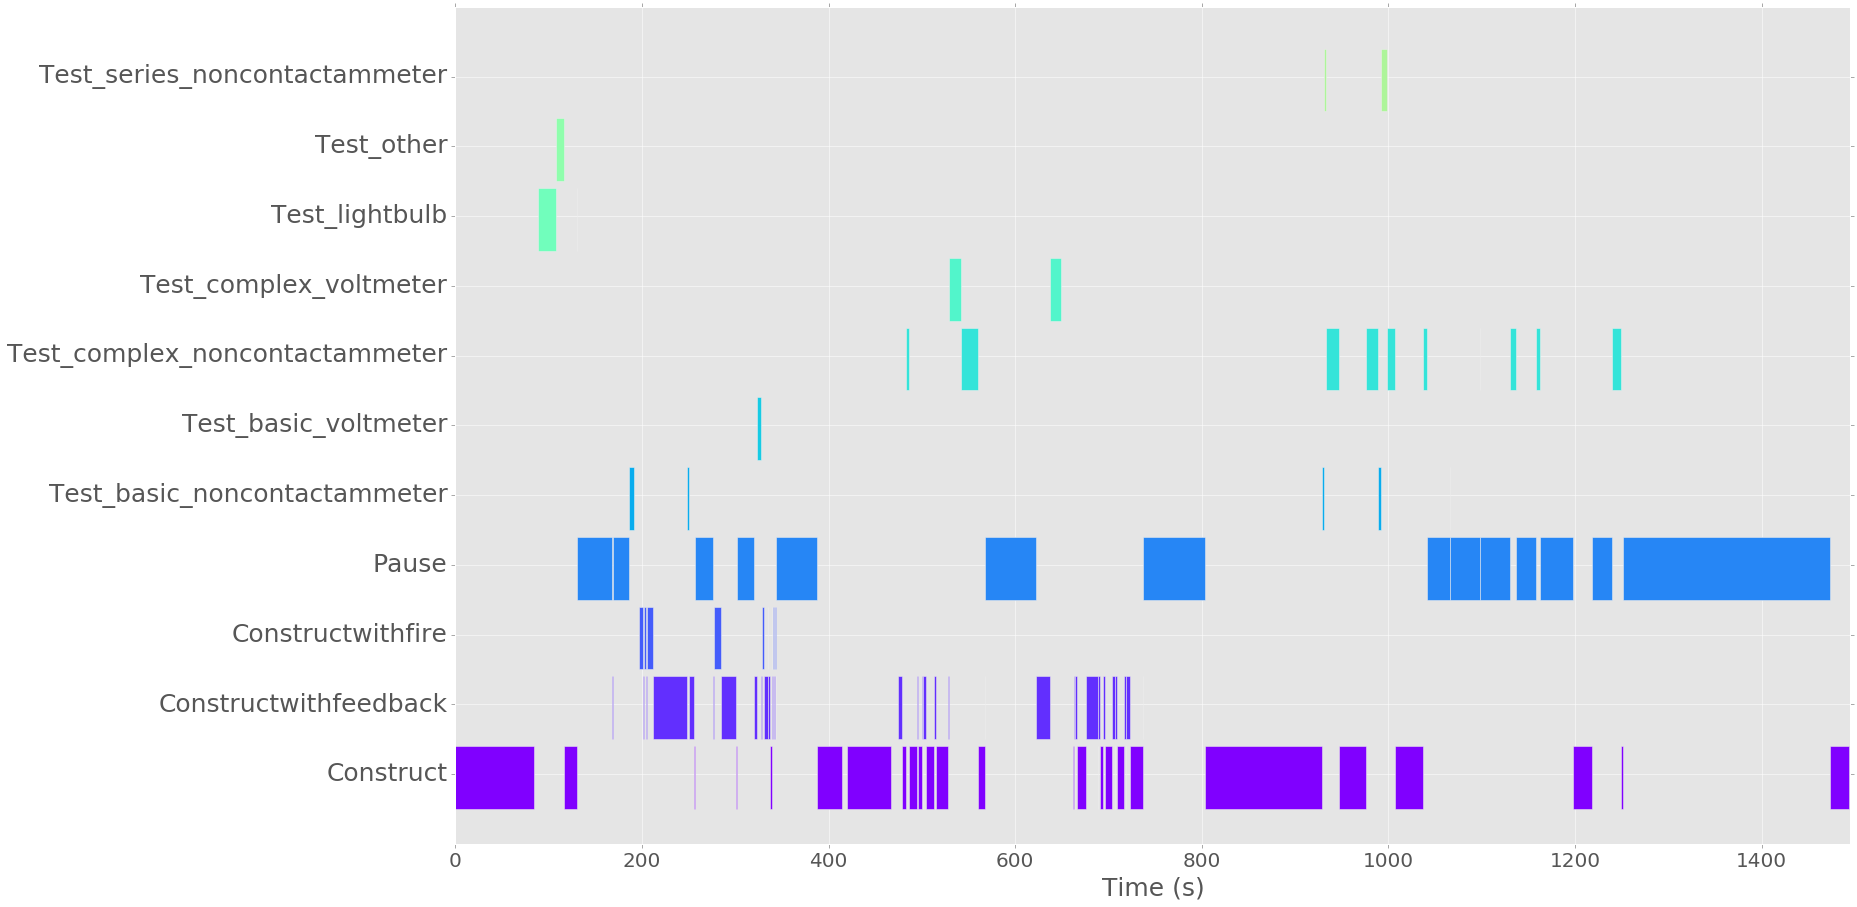

In [126]:
def plot_barGraph_new(df,ACTIVITY, studentID, pltFamilies):
    
    #get blocks of actions and their time coordinate for broken bar plot
    blocks, time_coord = get_blocks_withTime_new(df[df.Activity==ACTIVITY],{studentID},add_spaces=False, ignore = [], start = False)
    #create figure and axes
    fig, ax = plt.subplots()
    #set figure size
    #need this to convert desired action families back to letter code

    def convert(action,ignore):
        return converter[action]
    nn=1
    colorArr=iter(plt.cm.rainbow(np.linspace(0,1,len(pltFamilies))))
    
    splitblocks = re.compile(r'([A-Z]{1}[a-z]{0,2})\1*').split(blocks[studentID])
    splitblocks = [s for s in splitblocks if s != ""]
    axis_labels = []
    for action in pltFamilies: 
        #next 2 lines sample out relevant action blocks for one broken horizontal bar
        #print action
        #print (blocks[studentID])
        #print len(splitblocks), len(time_coord)
        if convert(action,[]) in splitblocks:
            axis_labels.append(action)
#             print convert(action,[])
#             print sum([1 for s in splitblocks if s ==convert(action,()) ])
            #out = [(x,y) for x,y in zip(splitblocks,time_coord) if any(convert(action,[]) == z for z in x)]
            out = [(x,y) for x,y in zip(splitblocks,time_coord) if convert(action,[]) == x]
            try:
                junk, time_coord_filtered = map(list,zip(*out))  
                ax.broken_barh(time_coord_filtered,(10*nn,9),facecolors=next(colorArr))
                nn+=1
            except:
                print 'failed', action,convert(action,[])
#                 for x,y in zip(splitblocks,time_coord):
#                     print convert(action,[]), x,y, convert(action,[]) == x
                pass
    ax.set_ylim(5, len(axis_labels)*10+15)
    ax.set_xlim(0, time_coord[-1][0]+time_coord[-1][1]+2)
    ax.set_xlabel('Time (s)', fontsize=25)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.set_yticks(range(15,len(axis_labels)*10+15,10))
    ax.set_yticklabels(axis_labels, fontsize=25)
    ax.grid(True)
    
    plt.show()
plot_barGraph_new(dfx,'a2', 94792123, pltFamilies_new) 

## Plot broken bar plots for both activities and different archtypical students

In [ ]:
#creating new columns in df_scores to find interesting cases to look at
df_scores["learning diff a2"]=df_scores["z post t2"]-df_scores["z pre"]
df_scores["learning gains a2"]=(df_scores["post t2"]-df_scores["pre"])/df_scores["pre"]
df_scores.sort_values("learning diff a2")

In [ ]:
#Define what action families to plot and in what order.
#pltFamilies=['Construct', 'Organize', 'Interface', 'Extra', 'Pause', 'Test', 'ConstructWithFeedback', 'Reset']
pltFamilies=['Construct', 'Organize', 'ConstructWithFeedback','Pause', 'Test']
pltFamilies2=['Construct','Pause', 'Test']
pltFamilies3=['ContructWithFeedback','Construct','Pause', 'Test']

## Resistor activity

### Low to high scores

In [ ]:
df_scores[df_scores["student"]==86170104]  #high learning gains (low to high z-scores)

In [ ]:
plot_barGraph(df,'a2', 86170104, pltFamilies)  

In [ ]:
plot_barGraph(df,'a2', 86170104, pltFamilies)  

In [ ]:
df_scores[df_scores["student"]==1075123]  #high learning gains (low to high z-scores)

In [ ]:
plot_barGraph(df,'a2', 1075123, pltFamilies)  #another low to high z-scores

### High to low scores

In [ ]:
df_scores[df_scores["student"]==31091114]  #high learning gains (low to high z-scores)

In [ ]:
plot_barGraph(df,'a2',31091114, pltFamilies) #high low z-scores

In [ ]:
df_scores[df_scores["student"]==13205111]

In [ ]:
plot_barGraph(df,'a2',13205111, pltFamilies) #high low z-scores

### Low to low scores

In [ ]:
df_scores[df_scores["student"]==8889108]

In [ ]:
plot_barGraph(df,'a2',8889108, pltFamilies) #low low z-scores

In [ ]:
df_scores[df_scores["student"]==19930112]

In [ ]:
plot_barGraph(df,'a2',19930112, pltFamilies) #low low z-scores

### High to high scores

In [ ]:
df_scores[df_scores["student"]==8580120]

In [ ]:
plot_barGraph(df,'a2',8580120, pltFamilies) #high high z-scores

In [ ]:
df_scores[df_scores["student"]==18838125]

In [ ]:
plot_barGraph(df,'a2',18838125, pltFamilies) #high high z-scores

## Plotting fewer action families: Construct = (Construct, ConstructWithFeedback, Organize)

### Low to high

In [ ]:
plot_barGraph(df2,'a2', 86170104, pltFamilies2) 

### High high

In [ ]:
plot_barGraph(df2,'a2',8580120, pltFamilies2) #high high z-scores

### High to low

In [ ]:
plot_barGraph(df2,'a2',31091114, pltFamilies2) #high low z-scores

### Low to low

In [ ]:
plot_barGraph(df2,'a2',8889108, pltFamilies2) #low low z-scores

In [ ]:
plot_barGraph(df,'a2',94792123, pltFamilies)

In [ ]:
plot_barGraph(df3,'a2',94792123, pltFamilies)